# IIC-3641 GML UC

In [1]:
import torch
print(torch.__version__)

2.4.0+cu121


In [2]:
import dgl
print(dgl.__version__)

/home/marcelo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.4.0


In [3]:
import os

os.environ['TORCH'] = torch.__version__
os.environ['DGLBACKEND'] = "pytorch"

## Definimos la matriz de incidencia sobre la base de dos tensores, uno con los ids de nodos y otro con los de hiperenlaces. La relación entre ambos (par) indica donde queda cada nodo.

In [4]:
import dgl.sparse as dglsp

H = dglsp.spmatrix(
    torch.LongTensor([[0, 1, 2, 2, 2, 2, 3, 4, 5, 5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10],
                      [0, 0, 0, 1, 3, 4, 2, 1, 0, 2, 3, 4, 2, 1, 3, 1, 3, 2, 4, 4]])
)

print(H.to_dense())

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1.]])


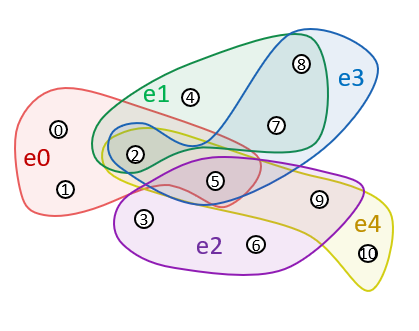

In [5]:
from IPython.display import Image

Image(filename='hgnn.png')

## La suma 1 o 0 (fila o columna) entrega la suma a nivel de filas o columnas de H, las que se corresponden con las distribuciones de grado

In [6]:
node_degrees = H.sum(1)
print("Node degrees", node_degrees)

hyperedge_degrees = H.sum(0)
print("Hyperedge degrees", hyperedge_degrees)

Node degrees tensor([1., 1., 4., 1., 1., 4., 1., 2., 2., 2., 1.])
Hyperedge degrees tensor([4., 4., 4., 4., 4.])


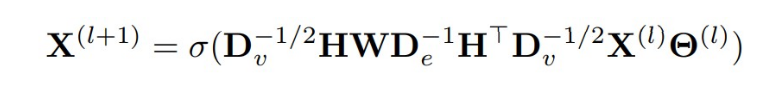

In [7]:
Image(filename='hgnn_eq.png')

## El Laplaciano está implementado como se indica en la ecuación.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from dgl.data import CoraGraphDataset
from torchmetrics.functional import accuracy


class HGNN(nn.Module):
    def __init__(self, H, in_size, out_size, hidden_dims=16):
        super().__init__()

        self.W1 = nn.Linear(in_size, hidden_dims)
        self.W2 = nn.Linear(hidden_dims, out_size)
        self.dropout = nn.Dropout(0.5)

        ###########################################################
        # (HIGHLIGHT) Compute the Laplacian with Sparse Matrix API
        ###########################################################
        # Compute node degree.
        d_V = H.sum(1)
        # Compute edge degree.
        d_E = H.sum(0)
        # Compute the inverse of the square root of the diagonal D_v.
        D_v_invsqrt = dglsp.diag(d_V**-0.5)
        # Compute the inverse of the diagonal D_e.
        D_e_inv = dglsp.diag(d_E**-1)
        # In our example, B is an identity matrix.
        n_edges = d_E.shape[0]
        W = dglsp.identity((n_edges, n_edges))
        # Compute Laplacian from the equation above.
        self.L = D_v_invsqrt @ H @ W @ D_e_inv @ H.T @ D_v_invsqrt

    def forward(self, X):
        X = self.L @ self.W1(self.dropout(X))
        X = F.relu(X)
        X = self.L @ self.W2(self.dropout(X))
        return X

## Ahora leemos un dataset y creamos H

In [9]:
def load_data():
    dataset = CoraGraphDataset()

    graph = dataset[0]
    indices = torch.stack(graph.edges())
    H = dglsp.spmatrix(indices)
    H = H + dglsp.identity(H.shape)

    X = graph.ndata["feat"]
    Y = graph.ndata["label"]
    train_mask = graph.ndata["train_mask"]
    val_mask = graph.ndata["val_mask"]
    test_mask = graph.ndata["test_mask"]
    return H, X, Y, dataset.num_classes, train_mask, val_mask, test_mask

## Para entrenar usamos las máscaras de nodos que vienen en el dataset

In [10]:
def train(model, optimizer, X, Y, train_mask):
    model.train()
    Y_hat = model(X)
    loss = F.cross_entropy(Y_hat[train_mask], Y[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def evaluate(model, X, Y, val_mask, test_mask, num_classes):
    model.eval()
    Y_hat = model(X)
    val_acc = accuracy(
        Y_hat[val_mask], Y[val_mask], task="multiclass", num_classes=num_classes
    )
    test_acc = accuracy(
        Y_hat[test_mask],
        Y[test_mask],
        task="multiclass",
        num_classes=num_classes,
    )
    return val_acc, test_acc

In [11]:
H, X, Y, num_classes, train_mask, val_mask, test_mask = load_data()
model = HGNN(H, X.shape[1], num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

with tqdm.trange(500) as tq:
    for epoch in tq:
        train(model, optimizer, X, Y, train_mask)
        val_acc, test_acc = evaluate(
            model, X, Y, val_mask, test_mask, num_classes
        )
        tq.set_postfix(
            {
                "Val acc": f"{val_acc:.5f}",
                "Test acc": f"{test_acc:.5f}",
            },
            refresh=False,
        )

print(f"Test acc: {test_acc:.3f}")

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


  0%|                                                                                                                 | 0/500 [00:00<?, ?it/s]/home/marcelo/.local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.44it/s, Val acc=0.80200, Test acc=0.82200]

Test acc: 0.822
